# Imports

In [1]:
# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
mne.set_log_level('WARNING')

In [4]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# MAIN

In [5]:
# Instantiate NIRS() and read data
nirs = NIRS().read(1, 1, 3, augment=True, transform=False, correction_factor='default')

In [6]:
# Pre-process the data using the default pipeline, with dpf/ppf as argument (default `constants.PPF`)
# Output is a dictionary of intermediate mne.Raw instances
# Stages: CW     (raw signal)
#         CWx    (backlight removed raw signal)
#         OD     (optical density)
#         TDD    (motion artifact removal)
#         SSR    (short-channel regression)
#         HB     (chromophore/haemoglobin)
#         FL     (bandpass filtering)
#         NCE    (negative correlation improvement)
savepoints = nirs.default_pipeline(remove_backlight=False,
                                   tddr=True,
                                   short_channel_regression=False,
                                   bandpass=False,
                                   negative_correlation_enhancement=False)

---

---

In [7]:
raw_intensity = savepoints['CW']
raw_haemo = nirs.raw.copy().pick('hbo')

In [8]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model='spm', # 'spm + derivative + dispersion'
                                                                            # drift_model='polynomial', # 'cosine'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [9]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)

---

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

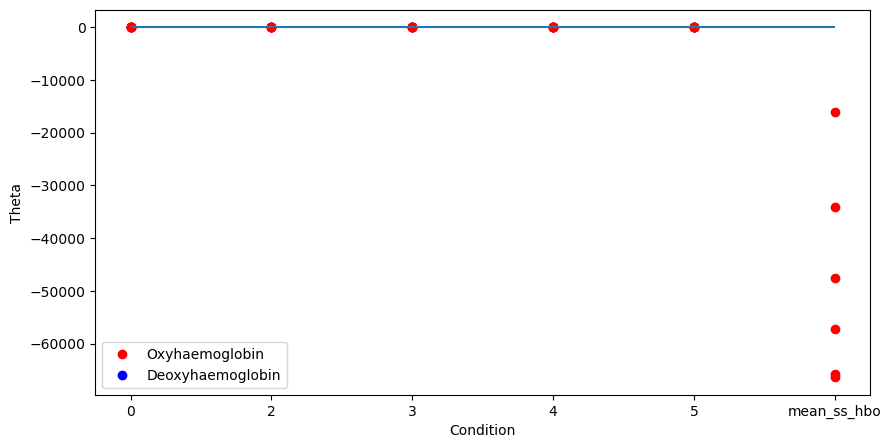

In [10]:
# Visualize regression coefficients for all channels

glm_est.scatter()